In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL.Image as Image
import os
import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import tensorflow_hub as hub


Download transfer learning to identify image within 1000 classes

In [3]:
IMAGE_SHAPE = (224, 224)

model =     hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1", 
                   input_shape=IMAGE_SHAPE+(3,))


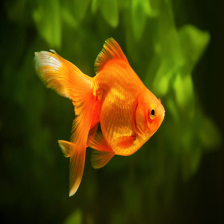

In [7]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [10]:
gold_fish_array = np.array(gold_fish)/255.0
gold_fish_array

array([[[0.01176471, 0.03529412, 0.        ],
        [0.01960784, 0.04313725, 0.        ],
        [0.02352941, 0.04705882, 0.        ],
        ...,
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ]],

       [[0.01176471, 0.03529412, 0.        ],
        [0.01960784, 0.04313725, 0.        ],
        [0.02745098, 0.04705882, 0.        ],
        ...,
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ]],

       [[0.01176471, 0.03529412, 0.        ],
        [0.01960784, 0.04313725, 0.        ],
        [0.02745098, 0.05098039, 0.00392157],
        ...,
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ],
        [0.07058824, 0.08235294, 0.        ]],

       ...,

       [[0.01176471, 0.01176471, 0.00392157],
        [0.01176471, 0.01176471, 0.00392157],
        [0.01176471, 0

In [11]:
gold_fish_array.shape

(224, 224, 3)

In [14]:
#since classifier takes multiple image as input
gold_fish_array[np.newaxis,...].shape

(1, 224, 224, 3)

In [18]:
predicted_result = model(gold_fish_array[np.newaxis,...])
predicted_result.shape

TensorShape([1, 1001])

In [19]:
label_index = np.argmax(predicted_result)
label_index

2

In [24]:
with open('labels.txt','r') as f:
    image_labels = f.read().splitlines()
image_labels[label_index]

'goldfish'

In [34]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 118s 1us/step


In [41]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [42]:
flower_image_dict = {
    'roses': list(data_dir.glob("roses/*")),
    'daisy': list(data_dir.glob("daisy/*")),
    'dandelion': list(data_dir.glob("dandelion/*")),
    'sunflowers': list(data_dir.glob("sunflowers/*")),
    'tulips': list(data_dir.glob("tulips/*")),
}
flower_label_dict = {
    'roses':0, 
    'daisy':1, 
    'dandelion':2, 
    'sunflowers':3,
    'tulips':4,
}

In [48]:
X,y = [],[]

for flower_name,images in flower_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224))
        X.append(resized_img)
        y.append(flower_label_dict[flower_name])

In [49]:
x = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [50]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
X_test_scaled

array([[[[0.14901961, 0.10588235, 0.09019608],
         [0.15294118, 0.09411765, 0.08627451],
         [0.10980392, 0.07843137, 0.09411765],
         ...,
         [0.16078431, 0.17254902, 0.18823529],
         [0.16078431, 0.17254902, 0.18823529],
         [0.16470588, 0.17647059, 0.19215686]],

        [[0.15294118, 0.12941176, 0.1254902 ],
         [0.17254902, 0.1254902 , 0.12156863],
         [0.15294118, 0.12156863, 0.1254902 ],
         ...,
         [0.20392157, 0.22745098, 0.23921569],
         [0.19607843, 0.21960784, 0.23137255],
         [0.2       , 0.21960784, 0.23137255]],

        [[0.14509804, 0.1372549 , 0.12941176],
         [0.16470588, 0.13333333, 0.12941176],
         [0.17254902, 0.13333333, 0.13333333],
         ...,
         [0.19607843, 0.22352941, 0.23921569],
         [0.18823529, 0.21176471, 0.23137255],
         [0.18823529, 0.21568627, 0.23137255]],

        ...,

        [[0.2627451 , 0.29803922, 0.56862745],
         [0.23137255, 0.2627451 , 0.52941176]

Now use this transfer learning model to classify our flower classes

In [51]:
# Load the model
hub_model = hub.load("https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5")

# Wrap the hub model in a Keras Layer
def hub_model_wrapper(x):
    return hub_model(x)

pretrained_model_without_top_layer = tf.keras.layers.Lambda(hub_model_wrapper, input_shape=IMAGE_SHAPE+(3,))

# Build your model
transfer_model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(5)
])

C:\Program Files\Anaconda3\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
transfer_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,405 (25.02 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
transfer_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [54]:
transfer_model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.5848 - loss: 1.0595
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.8895 - loss: 0.3878
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.9218 - loss: 0.2843
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.9347 - loss: 0.2453
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9424 - loss: 0.2090


In [56]:
transfer_model.evaluate(X_test_scaled, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8768 - loss: 0.3234


[0.3096456825733185, 0.888283371925354]

In [79]:
rose_image = Image.open('daisy1.jpg').resize(IMAGE_SHAPE)
rose_array_image = np.array(rose_image)/255.0
rose_array_image.shape

(224, 224, 3)

In [80]:
predicted_flower = transfer_model.predict(rose_array_image[np.newaxis,...])
np.argmax(predicted_flower)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


1